### Alternative to Data Prep 1:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re

In [8]:
# Import data:
train = pd.read_csv('data/TrainingSet.csv',index_col=0)
submission = pd.read_csv('data/SubmissionRows.csv',index_col=0)

In [22]:
train.T.head().describe()

,0,1,2,4,5,6,8,9,10,11,...,286107,286108,286109,286110,286112,286113,286114,286115,286116,286117
count,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
unique,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Remove [YR****] and input '_' for last 3 cols
train.columns = list(map(lambda x: re.findall(r'\d+',x)[0],train.columns[:36])) + list(map(lambda x: '_'.join(x.split()),train.columns[36:]))

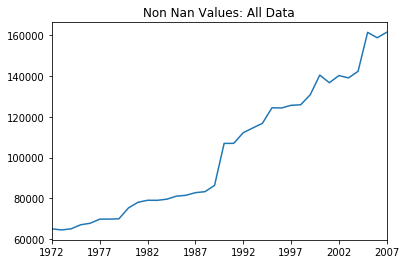

In [10]:
# Non NaN Rows (indicators). Clearly we have less missing values as the years increase.
train.loc[:,:'2007'].count().plot(title='Non Nan Values: All Data')

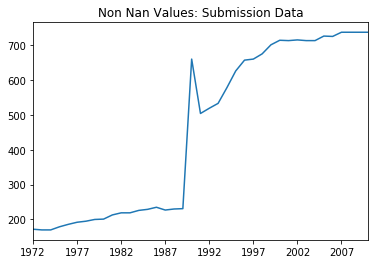

In [11]:
# Look out the rows we are trying to predict:
indx_submission = submission.index

data_submission = train.loc[indx_submission,:]

# Non Nan Rows of submission data: Around 1990 we had a spike of more information
data_submission.count().plot(title='Non Nan Values: Submission Data')

### Strategy:

- Look to filter that data outside of submission index based on either countries or indicators that need predicting (submission indexes)

- Try grouping by Series Code and then taking correlations between them to get a rough correlation guide

In [12]:
# Try countries:
countries_sub = data_submission.Country_Name.unique()

train_countries = train[train['Country_Name'].isin(countries_sub)]

In [13]:
# Here are the countries not in the submission index: We can safely remove these.
set(train['Country_Name'].unique()).difference(set(countries_sub))

{'American Samoa',
 'Channel Islands',
 'Curacao',
 'Isle of Man',
 'Kosovo',
 'Sint Maarten (Dutch part)',
 'St. Martin (French part)',
 'Turks and Caicos Islands'}

In [14]:
# Look at indicators: Submission data
data_submission['Series_Code'].value_counts()

8.16    200
4.1     192
7.8     154
6.1     105
2.1      81
5.1       4
6.7       1
Name: Series_Code, dtype: int64

In [15]:
submission_s_code = data_submission['Series_Code'].unique()

Number of training instances:  1114


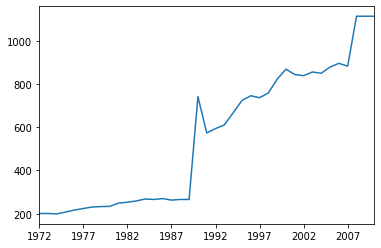

In [118]:
# Filter training data again to only inc. Series codes in submission data
train_countries[train_countries['Series_Code'].isin(submission_s_code)].count().plot()
print('Number of training instances: ',len(train_countries[train_countries['Series_Code'].isin(submission_s_code)]))

We only have 1114 training values using the above method and likely to be missing a lot of key information during the model building stage.

We will try to look at indicators with entire data collected from the time periods (1972+) and add this to the dataframe data_submission.

First check to see if data with entire time period inc. indexes of data_submission.

#### Groupby country code: Correlations

In [16]:
s_code = train_countries[train_countries['Series_Code'].isin(submission_s_code)]

In [19]:
submission_s_code

array(['7.8', '8.16', '4.1', '6.1', '2.1', '5.1', '6.7'], dtype=object)

In [120]:
corr_group = train.groupby('Series_Code').mean().T.corr()[submission_s_code]
corr_group.head(10)

Series_Code,7.8,8.16,4.1,6.1,2.1,5.1,6.7
Series_Code,,,,,,,
1.2,-0.774399,-0.400163,0.547024,-0.751408,-0.479661,-0.122723,-0.541525
2.1,0.974165,0.880825,-0.907490,0.741725,1.000000,0.010213,0.363031
3.2,0.828248,0.754906,-0.850693,0.824610,0.777868,-0.443204,0.508213
4.1,-0.998060,-0.722675,1.000000,-0.791391,-0.907490,-0.124832,-0.537280
5.1,-0.223360,-0.091865,-0.124832,-0.220683,0.010213,1.000000,0.064563
6.1,0.765506,0.629139,-0.791391,1.000000,0.741725,-0.220683,-0.696318
6.7,0.546451,0.535112,-0.537280,-0.696318,0.363031,0.064563,1.000000
7.8,1.000000,0.980500,-0.998060,0.765506,0.974165,-0.223360,0.546451
8.16,0.980500,1.000000,-0.722675,0.629139,0.880825,-0.091865,0.535112


In [121]:
# Set threshold =7, e.g. all indicators on avg have a corr of abs(x)>0.5 against the series codes given in submission data
s_code_keep = corr_group.where(abs(corr_group)>0.5).dropna(thresh=7).index
corr_group.where(abs(corr_group)>0.6).dropna(thresh=7)

Series_Code,7.8,8.16,4.1,6.1,2.1,5.1,6.7
Series_Code,,,,,,,
DT.NFL.IAEA.CD,-1.000000,-1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000
EN.ATM.GHGO.KT.CE,0.989279,0.999326,-0.983936,0.795005,0.987065,-0.871433,1.000000
EN.ATM.HFCG.KT.CE,0.992971,0.997911,-0.988536,0.811630,0.991156,-0.857399,1.000000
EN.ATM.METH.EG.ZS,0.979701,0.926754,-0.985769,0.954329,0.982497,-0.651626,1.000000
EN.ATM.NOXE.EG.KT.CE,0.989816,0.947290,-0.993965,0.935056,0.991770,-0.695213,1.000000
EN.ATM.NOXE.IN.KT.CE,-0.982799,-0.932677,0.988346,-0.949400,-0.985366,0.663743,-1.000000
EN.ATM.PFCG.KT.CE,-0.983050,-0.933168,0.988552,-0.948971,-0.985598,0.664762,-1.000000
EN.ATM.SF6G.KT.CE,0.916625,0.974131,-0.902969,0.608631,0.910751,-0.969406,1.000000
IC.ELC.OUTG,1.000000,1.000000,-1.000000,-1.000000,1.000000,-1.000000,-1.000000


In [122]:
# Combine the required codes
s_codes = list(s_code_keep) + list(submission_s_code)

# Filter train data (frame which removed unwanted countries):
train_subset = train_countries[train_countries['Series_Code'].isin(s_codes)]
train_subset.head()

,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,...,2001,2002,2003,2004,2005,2006,2007,Country_Name,Series_Code,Series_Name
16,NaN,NaN,0.267007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Afghanistan,2.1,Achieve universal primary education
243,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,52.800000,75.200000,67.400000,84.600,Afghanistan,IC.REG.COST.PC.ZS,Cost of business start-up procedures (% of GNI...
559,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.256000,0.291000,0.325000,0.360000,0.395000,0.430000,0.465,Afghanistan,7.8,Ensure environmental sustainability
618,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000047,0.000046,0.000879,0.001058,0.012241,0.021071,0.019,Afghanistan,8.16,Develop a global partnership for development: ...
660,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,20.000000,NaN,NaN,Afghanistan,SH.MMR.RISK,Lifetime risk of maternal death (1 in: rate va...


### Strategy 2:

- Inspect distribution of Non NAN values

- Take advantage of other statistical techniques such as interpolation (Linear/Polynomial is yet to be decided)

- Apply Interpolation

Text(0, 0.5, 'Volume')

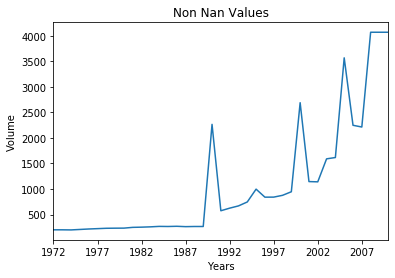

In [123]:
# Inspection: 
train_subset.count().plot()
plt.title('Non Nan Values')
plt.xlabel('Years')
plt.ylabel('Volume')

We see from the above that we can capitalize by introducing interpolation to fill in the 'gaps' for years > 1990!

In [124]:
train_int = train_subset.loc[:,:'2007']

# Interpolate: Linear:
train_int = train_int.interpolate(axis=1)

#### View Before vs After Interpolation:

Taking a small sample, we see that the benefits are clearly visible.

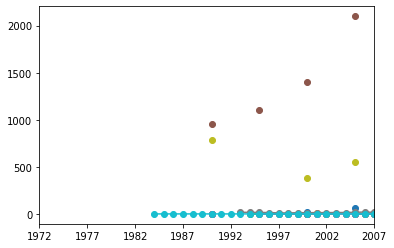

In [127]:
# Before:
train_subset.T.iloc[:36,20:30].plot(marker='o',legend=False)

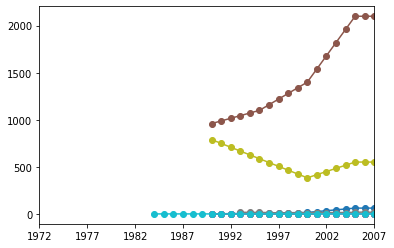

In [128]:
# After
train_int.T.iloc[:,20:30].plot(marker='o',legend=False)

Text(0, 0.5, 'Volume')

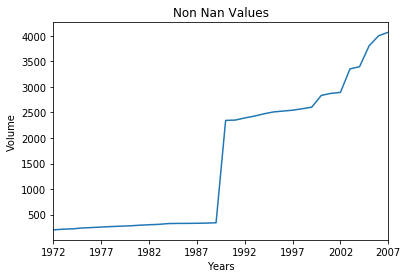

In [129]:
# Now we have a larger period to play with:
train_int.count().plot()
plt.title('Non Nan Values')
plt.xlabel('Years')
plt.ylabel('Volume')

### Strategy 3:

- Export .csv

In [130]:
train_int.to_csv('data/TrainingSet_Cleaned.csv')